In [1]:
import keras  # расскоментируйте эту строку, чтобы начать обучение
from keras.datasets import cifar100
from keras.utils import np_utils
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalMaxPooling2D,  GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import efficientnet.keras as efn 

Using TensorFlow backend.


In [2]:
# установка параметров нейросети
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
batch_size = 8
num_classes = 100
epochs = 50
data_augmentation = True
#num_predictions = 20
lr = 1e-3
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar100_trained_model.h5'

In [3]:
nb_train_samples = 50000 # 50000 train выборка приходится ограничивать т.к. при стандартном выборке размер привышает 28 Gb 
nb_valid_samples = 10000 # 10000 test выборка

def load_cifar10_data(height, width):

    # Load cifar100 training and test sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar100.load_data()

    # Изменить размера образов
    if keras.backend.image_data_format() == 'th':
        X_train = np.array([cv2.resize(img.transpose(1,2,0), (height,width)).transpose(2,0,1) for img in X_train[:nb_train_samples,:,:,:]])
        X_valid = np.array([cv2.resize(img.transpose(1,2,0), (height,width)).transpose(2,0,1) for img in X_valid[:nb_valid_samples,:,:,:]])
    else:
        X_train = np.array([cv2.resize(img, (height,width)) for img in X_train[:nb_train_samples,:,:,:]])
        X_valid = np.array([cv2.resize(img, (height,width)) for img in X_valid[:nb_valid_samples,:,:,:]])

    # Преобразование образцов в формат, совместимый с keras
    Y_train = keras.utils.to_categorical(Y_train[:nb_train_samples], num_classes)
    Y_valid = keras.utils.to_categorical(Y_valid[:nb_valid_samples], num_classes)

    return X_train, Y_train, X_valid, Y_valid

x_train, y_train, x_test, y_test = load_cifar10_data(height, width)

In [5]:
x_train.shape

(50000, 224, 224, 3)

In [4]:
# конфигурирование слоев нейросети
model = Sequential()
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = num_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [5]:
# инициализация RMSprop optimizer
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)

# компиляция модели
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.


es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, 
                        factor = 0.5, min_lr = 1e-6, verbose = 1)

if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                  validation_data=(x_test, y_test),
                                  epochs = epochs, 
                                  verbose = 1, 
                                  callbacks = [es, rlrop])

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

MemoryError: Unable to allocate 28.0 GiB for an array with shape (50000, 224, 224, 3) and data type float32

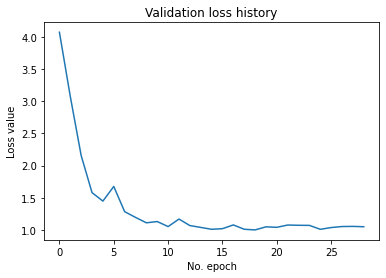

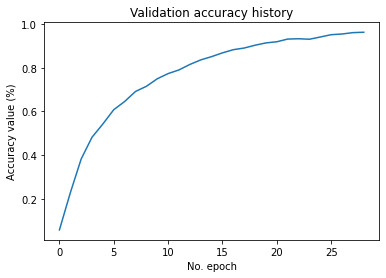

In [8]:
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['acc'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()